### **Задача:** 
#### Главная страница Яндекса. Поменяли местами иконки "Маркет" и "Карты" над строкой поиска. Необходимо проверить повлияло ли изменение, и стали ли пользователи чаще кликать на иконку "Маркета" по возвращению на сайт. Проверить гипотезу о кликабельности иконки с помощью метрики CTR (click-through-rate)

#### Визуальное представление: 

![title](https://glebk.notion.site/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F508924bd-55f1-4939-b522-b55c9c62b4c6%2F__2020-11-07__21.04.41.png?id=76e2e9fe-dd64-486c-9f63-00b2b2b2c96f&table=block&spaceId=35722ed8-6c4b-425b-98b1-d0f66af3980b&width=2000&userId=&cache=v2)

##### Формула кликабельности иконки маркета:   ${CTR} = \frac{\sum_{c_i \in C} Clicks} {\sum_{s_i \in S} Sessions}$


### Описание колонок

- `user_id` – идентификатор пользователя
- `session_id` – идентификатор сессии
- `click_id` – идентификатор клика
- `experimentVariant` – вариант эксперимента

### **Решение:**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
# Загрузка данных и общая информация о них

df = pd.read_csv('case_ctr.csv', sep = ';', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            10000 non-null  object
 1   session_id         10000 non-null  object
 2   click_id           7655 non-null   object
 3   experimentVariant  10000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 390.6+ KB


##### Разделим пользователей на 2 группы, где А - контрольная выборка, В - тестовая выборка. Видно, что пользователи в группах не пересекаются.

In [11]:
group_A = df[df['experimentVariant'] == 0]
group_B = df[df['experimentVariant'] == 1]

print('Пользователей в группе А:',len(group_A), '\nПользователей в группе B:',len(group_B))

Пользователей в группе А: 5112 
Пользователей в группе B: 4888


##### Сгруппируем данные о действиях пользователей по `user_id` для дальнейшего расчета метрики CTR

In [13]:
groupby_A = group_A.groupby(['user_id']).agg(clicks_count = pd.NamedAgg(column="click_id", aggfunc="count"), 
                                             sessions_count = pd.NamedAgg(column="session_id", aggfunc="count"))
                                            # count не учитывает NaN
groupby_B = group_B.groupby(['user_id']).agg(clicks_count = pd.NamedAgg(column="click_id", aggfunc="count"),
                                             sessions_count = pd.NamedAgg(column="session_id", aggfunc="count"))    
groupby_A                                                                                                                          

,clicks_count,sessions_count
user_id,,
002919af9552c77035b1da1a23988191,6,7
0036ea1469ecd0808170f942533513a2,3,5
00b31c2f7dfc7b377abe7e1bd2ac060e,2,2
01308b1cb36f52772b2ca6aa2fedd2e3,3,3
014a6b3970d823d330a583d674e18f9c,3,5
...,...,...
ff4536ae8f68e2fe7733ae78a9758918,4,6
ff6fbf9aeda1c7dbb702e1c07888f0c0,3,3
ff7c33f3635554df1593d383f8b8456d,8,12


#### Посмотрим, как распределилось количество сессий и кликов по группам.

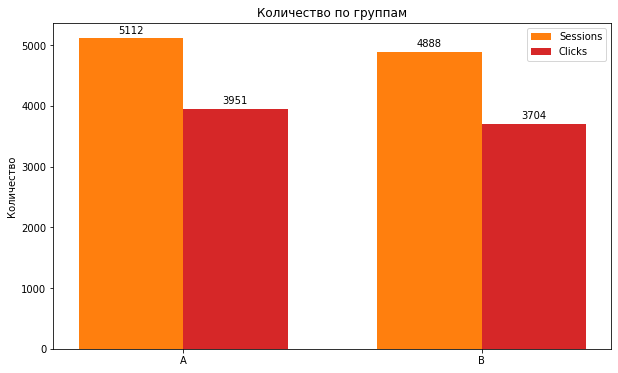

In [12]:
labels = ['A', 'B']
sessions = [groupby_A.sessions_count.sum(), groupby_B.sessions_count.sum()]
clicks = [groupby_A.clicks_count.sum(), groupby_B.clicks_count.sum()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = [10,6])

rects1 = ax.bar(x - width/2, sessions, width, label='Sessions',color = ['tab:orange'])
rects2 = ax.bar(x + width/2, clicks, width, label='Clicks', color = ['tab:red'])

ax.set_ylabel('Количество')
ax.set_title('Количество по группам')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

_Существенной разницы не видно._

#### Рассчитаем метрику CTR для обеих групп.

In [7]:
CTR_A = groupby_A.clicks_count.sum()/groupby_A.sessions_count.sum()
CTR_B = groupby_B.clicks_count.sum()/ groupby_B.sessions_count.sum()
print(round(CTR_A,3), ' ', round(CTR_B,3))
print('difference:', round(CTR_B - CTR_A,3))

0.773   0.758
difference: -0.015


#### В группе А:   $CTR = 0.773$
#### В группе В:   $CTR = 0.758$
####              $\Delta = -0.015$

##### По результатам расчета метрики CTR, можно предположить, что изменение мест иконок «Маркет» и «Карты», в итоге, отрицательно влияет на частоту кликов по иконке «Маркет».
##### Проверим **гипотезу** о том, что положение иконки «Маркет» в эксперименте значимо не влияет на количество кликов по ней.

_Направленность изменения глобального CTR такая же, как направленность изменения суммы кликов, если мы не влияем на просмотры в нашем эксперименте.  Это разумное предположение, так как мы работаем с таргетингом на иконку на главной странице.  Крайне маловероятно, что, изменив положение иконок, мы изменим среднее количество просмотров их пользователем, так как оно зависит от количества посещений главной страницы.
 Именно поэтому для проверки гипотезы я буду рассматривать распределение кликов. Так как данные являются качественными (был клик/ нет), предполагая, что выборки независимы, я буду использовать критерий хи-квадрат Пирсона._

In [14]:
ac = groupby_A.clicks_count.sum()
an = groupby_A.sessions_count.sum() - groupby_A.clicks_count.sum()
bc = groupby_B.clicks_count.sum()
bn = groupby_B.sessions_count.sum() - groupby_B.clicks_count.sum()

signs = pd.DataFrame({'был клик':[ac,bc],'не было':[an,bn]},index = ['A','B'])
signs

,был клик,не было
A,3951,1161
B,3704,1184


$\uparrow$ _Так выглядят суммарные данные о сочетании двух признаков: наличия клика и принадлежности к тестовой/ контрольной группе._

_Проверим на уровне значимости_ $p = 0,05$ _гипотезу_ $H_0$: _наличие клика у пользователя не зависит от его принадлежности к тестовой/ контрольной группе._

_С признаком наличия клика свяжем случайную величину_ $X$ _следующим образом:_ $\lbrace X = 1 \rbrace$ _— клик был,_ $\lbrace X = 0 \rbrace$ _— не было клика. Аналогично,_ $\lbrace Y = 1 \rbrace$ —_пользователь из группы В,_ $\lbrace Y = 0 \rbrace$ _— пользователь из группы А. Таким образом, проверка независимости признаков эквивалентна проверки независимости СВ $X$ и $Y$._

_В нашем эксперименте $X$ и $Y$ принимают только два значения, поэтому реализацию $\hat{g}_n$ статистики хи-квадрат $\hat{G}_n$ можно вычислить по формуле:_ $\hat{g}_n = \frac{n(n_11n_22 - n_12n_21)^2}{N_1N_2M_1M_2}$

In [17]:
# Функция для вычисления статистики критерия
def chi2_statistic(signs):
    n11 = signs.iloc[0,0]
    n21 = signs.iloc[1,0]
    n12 = signs.iloc[0,1]
    n22 = signs.iloc[1,1]
    n = n11+n12+n21+n22
    N1 = n11+n12
    N2 = n21+n22
    M1 = n11+n21
    M2 = n12+n22
    g = (n*(n11*n22-n12*n21)**2)/(N1*N2*M1*M2)
    return g

In [18]:
print('В нашем случае статистика критерия примет значение: ',chi2_statistic(signs))

В нашем случае статистика критерия примет значение:  3.179405297023079


Для $\alpha = 0,95$ критическая область $\Delta_p = (k_\alpha (1), +\infty) = (3,84, +\infty)$. Так как $\hat{g}_n \not\in \Delta_p$, гипотеза $H_0$ не отвергается.

Также можно было воспользоваться функцией `chi2_contingency` из библиотеки scipy. Она покажет такой же результат:

In [27]:
print('Статистика = ',scipy.stats.chi2_contingency([[ac,an],[bc,bn]], correction = False)[0],'\n p-value = ',scipy.stats.chi2_contingency([[ac,an],[bc,bn]], correction = False)[1])

Статистика =  3.179405297023071 
 p-value =  0.07457186628132746


#### **Из полученных результатов можно сделать вывод о том, что тест не изменил значимо метрику CTR. Изменение положения иконки не повлияло на количество кликов по ней.**

##### **Рекомендации:**

- Улучшить разделение пользователей на тест и контроль так, чтобы выборки были по-прежнему сбалансированы, а дисперсия разницы теста с контролем стала бы сама по себе меньше

_К примеру, можно применить стратификацию данных._

- Увеличить время проведения эксперимента

_В основном, чем дольше проходит эксперимент, тем вероятнее получить статистически значимые результаты, потому что в эксперименте поучаствует больше людей. Чем больше людей, тем меньше дисперсия у средних величин, а значит, меньше доверительный интервал. Это увеличивает вероятность задетектировать эффект.
Но чем больше вы держите тест, тем меньше гипотез протестируете за определённый промежуток времени._